# Template for analyzing the CLM5-PPE
- Updated Jan 27, 2023
- Daniel Kennedy, djk2120@ucar.edu

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import seaborn as sns

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("/glade/u/home/djk2120/ppe_tools")
from ppe_analysis.analysis import *

In [5]:
import panel as pn
import param
pn.extension()

## spin up some extra cores on CASPER

In [69]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44785 instead
  f"Port {expected} is already in use.\n"


In [70]:
client.cluster

In [66]:
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']

In [230]:
d='/glade/campaign/asp/djk2120/PPEn11/'

In [250]:
exp=exps[0]
tape='h0'
files=glob.glob(d+exp+'/hist/*OAAT*'+tape+'*')
mems=[f.split('OAAT')[1].split('.')[0] for f in sorted(files)]
s0=set(mems)

In [262]:
for exp in exps:
    tape='h5'
    files=glob.glob(d+exp+'/hist/*OAAT*'+tape+'*')
    mems=[f.split('OAAT')[1].split('.')[0] for f in sorted(files)]
    print(exp,len(mems))

CTL2010 504
C285 499
C867 499
AF1855 499
AF2095 499
NDEP 499


In [252]:
len(mems)

499

In [245]:
mems

['0000',
 '0001',
 '0002',
 '0003',
 '0004',
 '0005',
 '0006',
 '0007',
 '0008',
 '0009',
 '0010',
 '0011',
 '0012',
 '0013',
 '0014',
 '0015',
 '0016',
 '0017',
 '0018',
 '0019',
 '0020',
 '0021',
 '0022',
 '0023',
 '0024',
 '0025',
 '0026',
 '0027',
 '0028',
 '0029',
 '0030',
 '0031',
 '0032',
 '0033',
 '0034',
 '0035',
 '0036',
 '0037',
 '0038',
 '0039',
 '0040',
 '0041',
 '0042',
 '0043',
 '0044',
 '0045',
 '0046',
 '0047',
 '0048',
 '0049',
 '0050',
 '0051',
 '0052',
 '0053',
 '0054',
 '0055',
 '0056',
 '0057',
 '0058',
 '0059',
 '0060',
 '0061',
 '0062',
 '0063',
 '0064',
 '0065',
 '0066',
 '0067',
 '0068',
 '0069',
 '0070',
 '0071',
 '0072',
 '0073',
 '0074',
 '0075',
 '0076',
 '0077',
 '0078',
 '0079',
 '0080',
 '0081',
 '0082',
 '0083',
 '0084',
 '0085',
 '0086',
 '0087',
 '0088',
 '0089',
 '0090',
 '0091',
 '0092',
 '0093',
 '0094',
 '0095',
 '0096',
 '0097',
 '0098',
 '0099',
 '0100',
 '0101',
 '0102',
 '0103',
 '0104',
 '0105',
 '0106',
 '0107',
 '0108',
 '0109',
 '0110',
 

In [165]:
lhc/'
fs=[sorted(glob.glob(d+'*postSASU*h0.00'+str(y).zfill(2)+'*')) for y in [1,21,41]]
dvs=['TOTVEGC','TOTSOMC','TOTECOSYSC','TOTSOMC_1m','GPP','NPP','TLAI']
def preprocess(ds):
    return ds[dvs]
ds=xr.open_mfdataset(fs,combine='nested',concat_dim=['time','ens'],
                     preprocess=preprocess,parallel=True)
la=xr.open_dataset('landarea_transient.nc')['landarea']
cf1=24*60*60*365
cf2=1e-9
x=cf1*cf2*(la*ds.GPP).sum(dim='gridcell').compute()

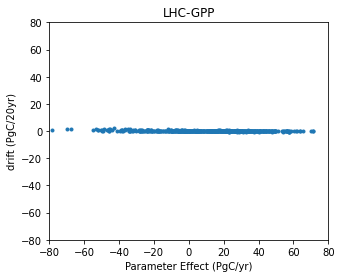

In [206]:
plt.figure(figsize=[5,4])
x1=x.sel(time=slice('0022','0041')).mean(dim='time').compute()
x2=x.sel(time=slice('0002','0021')).mean(dim='time').compute()
plt.plot(x1-x1.sel(ens=0),x2-x1,'.')
plt.xlim([-80,80])
plt.ylim([-80,80])
plt.xlabel('Parameter Effect (PgC/yr)')
plt.ylabel('drift (PgC/20yr)')
plt.title('LHC-GPP');

(array([  3.,   9.,  22.,  44.,  70.,  92., 113.,  84.,  48.,  16.]),
 array([-78.9370174 , -63.86363457, -48.79025173, -33.7168689 ,
        -18.64348607,  -3.57010323,  11.5032796 ,  26.57666244,
         41.65004527,  56.7234281 ,  71.79681094]),
 <BarContainer object of 10 artists>)

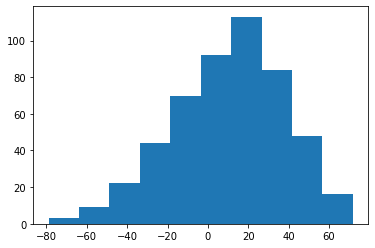

In [194]:
xx=x2.mean(dim='year').compute()
plt.hist(xx-xx.sel(ens=0))

In [84]:
for exp in exps:
    fs=np.unique([f.split('/')[-1].split('.')[0] for f in glob.glob(d)])
    print(exp,len(fs))

CTL2010 28
C285 28
C867 28
AF1855 28
AF2095 28
NDEP 28


In [83]:
fs

array(['PPEn11_AF2095_postSASU_OAAT0481',
       'PPEn11_AF2095_postSASU_OAAT0482',
       'PPEn11_AF2095_postSASU_OAAT0483',
       'PPEn11_AF2095_postSASU_OAAT0484',
       'PPEn11_AF2095_postSASU_OAAT0485',
       'PPEn11_AF2095_postSASU_OAAT0486',
       'PPEn11_AF2095_postSASU_OAAT0487',
       'PPEn11_AF2095_postSASU_OAAT0488',
       'PPEn11_AF2095_postSASU_OAAT0489',
       'PPEn11_AF2095_postSASU_OAAT0490',
       'PPEn11_AF2095_postSASU_OAAT0491',
       'PPEn11_AF2095_postSASU_OAAT0492',
       'PPEn11_AF2095_postSASU_OAAT0493',
       'PPEn11_AF2095_postSASU_OAAT0494',
       'PPEn11_AF2095_postSASU_OAAT0495',
       'PPEn11_AF2095_postSASU_OAAT0496',
       'PPEn11_AF2095_postSASU_OAAT0497',
       'PPEn11_AF2095_postSASU_OAAT0498',
       'PPEn11_AF2095_postSASU_OAAT0499',
       'PPEn11_AF2095_postSASU_OAAT0500',
       'PPEn11_AF2095_postSASU_OAAT0501',
       'PPEn11_AF2095_postSASU_OAAT0502',
       'PPEn11_AF2095_postSASU_OAAT0503',
       'PPEn11_AF2095_postSASU_OAA

In [68]:
for exp in exps:
    print(exp,len(glob.glob(d+exp+'/spin/*')))

CTL2010 112
C285 12744
C867 47040
AF1855 47040
AF2095 47040
NDEP 40320


In [15]:
la=xr.open_dataset('landarea_oaat.nc').landarea

In [8]:
x1=xr.open_dataset('../data/FCTR.nc')['FCTR_glob_mean']
x2=xr.open_dataset('../data/GPP.nc')['GPP_glob_mean']

In [6]:
def get_df(v,d='glob',op='mean',cf=1):
    v0=v
    if v=='CUE':
        v=('NPP','GPP')
        cfs=(1,1)
    elif v=='WUE':
        v=('GPP','FCTR')
        cfs=(1,1.707)
    if type(v) is str:
        x=cf*xr.open_dataset('../data/'+v+'.nc')[v+'_'+d+'_'+op]
    else:
        xs= [xr.open_dataset('../data/'+vv+'.nc')[vv+'_glob_mean'] for vv in v]
        x=(cfs[0]*xs[0])/(cfs[1]*xs[1])
        
    x[4,58]=np.nan
    exps=x.exp.values
    nens=len(x.ens)
    df=pd.DataFrame({v0:np.concatenate([x for x in x]),
                 'Experiment':np.repeat(exps,nens)})    
    
    return df

In [81]:
len(df)/6

373.0

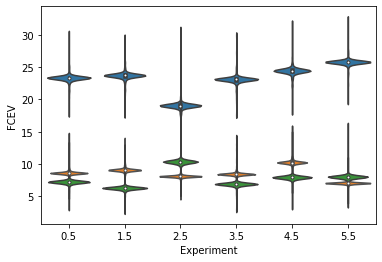

In [84]:
for i,v in enumerate(['FCTR','FGEV','FCEV']):
    df=get_df(v)
    df['Experiment']=np.repeat(i/4+np.arange(6),373)
    sns.violinplot(data=df,x='Experiment',y=v,orient='v',color='C'+str(i),label=v)



<AxesSubplot:xlabel='Experiment', ylabel='NBP'>

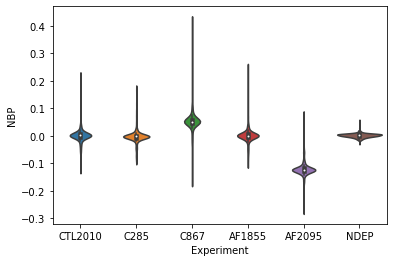

In [33]:

v='NBP'
df=get_df(v)
sns.violinplot(data=df,x='Experiment',y=v,orient='v')

In [10]:
gpp=xr.open_dataset('../data/GPP.nc')['GPP_glob_mean']
hr=xr.open_dataset('../data/HR.nc')['HR_glob_mean']
ar=xr.open_dataset('../data/AR.nc')['AR_glob_mean']

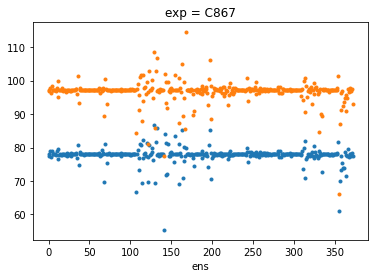

In [23]:
(gpp-ar).sel(exp='NDEP').plot.line('.')
(gpp-ar).sel(exp='C867').plot.line('.')

(0.0, 100.0)

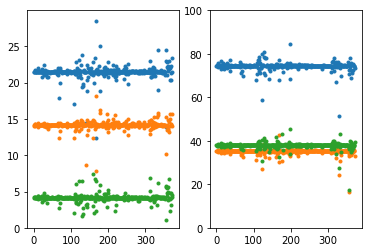

In [32]:
plt.subplot(121)
plt.plot(gpp.sel(exp='NDEP')-gpp.sel(exp='CTL2010'),'.')
plt.plot(hr.sel(exp='NDEP')-hr.sel(exp='CTL2010'),'.')
plt.plot(ar.sel(exp='NDEP')-ar.sel(exp='CTL2010'),'.')
plt.ylim(bottom=0)
plt.subplot(122)
plt.plot(gpp.sel(exp='C867')-gpp.sel(exp='CTL2010'),'.')
plt.plot(hr.sel(exp='C867')-hr.sel(exp='CTL2010'),'.')
plt.plot(ar.sel(exp='C867')-ar.sel(exp='CTL2010'),'.')
plt.ylim([0,100])

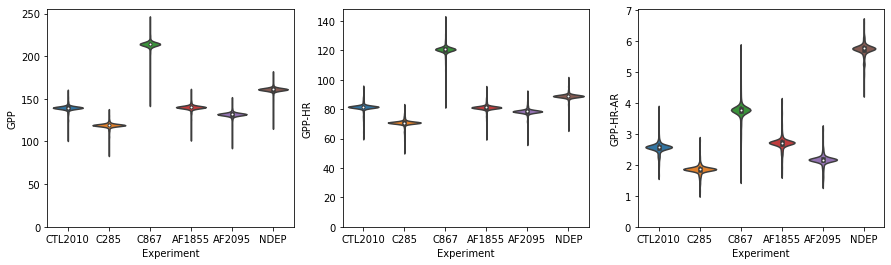

In [25]:
x=gpp
v='GPP'
i=0
plt.figure(figsize=[15,4])
for m in [0,hr,ar]:
    i+=1
    x=x-m
    if i==2:
        v=v+'-HR'
    if i==3:
        v=v+'-AR'
    x[4,58]=np.nan
    exps=x.exp.values
    nens=len(x.ens)
    df=pd.DataFrame({v:np.concatenate([x for x in x]),
                 'Experiment':np.repeat(exps,nens)})

    plt.subplot(1,3,i)
    sns.violinplot(data=df,x='Experiment',y=v,orient='v')
    plt.ylim(bottom=0)

In [12]:
for exp in ['CTL2010','NDEP']:
    print(exp)
    for x in [gpp,hr,ar]:
        print(np.round(x.sel(exp='C867').mean().values-x.sel(exp=exp).mean().values,1))

CTL2010
74.2
35.2
37.9
NDEP
52.8
21.0
33.7


In [123]:
y.sel(exp='NDEP').mean()-y.sel(exp='C867').mean()

<xarray.DataArray 'HR_glob_mean' ()>
array(-21.02940929)

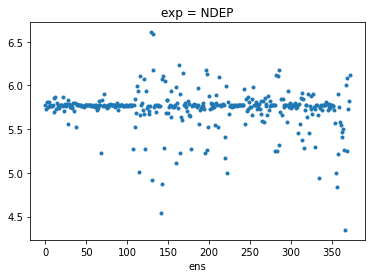

In [117]:
exp='NDEP'
(x-y).sel(exp=exp).plot.line('.')

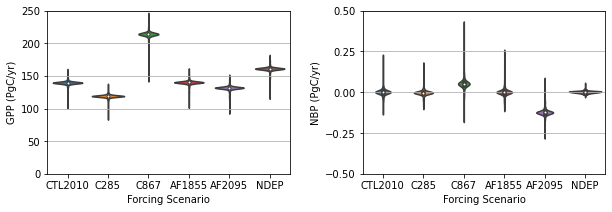

In [39]:
plt.figure(figsize=[10,3])
i=0
ys={'GPP':(0,250),'NBP':(-0.5,0.5)}
nx=6
u='PgC/yr'
for v in ['GPP','NBP']:
    i+=1
    plt.subplot(1,2,i)
    df=get_df(v)
    sns.violinplot(data=df,x='Experiment',y=v,orient='v')
    plt.ylim(ys[v])
    plt.yticks(np.linspace(ys[v][0],ys[v][1],nx))
    plt.grid(axis='y')
    
    plt.xlabel('Forcing Scenario')
    nx=5
    

    plt.ylabel(v+' ('+u+')')

plt.subplots_adjust(wspace=0.3)
    
    
plt.savefig('../figs/violins.pdf',bbox_inches='tight')

In [44]:
ds=xr.open_dataset('../data/NBP.nc')
nbp=ds['NBP_glob_mean']

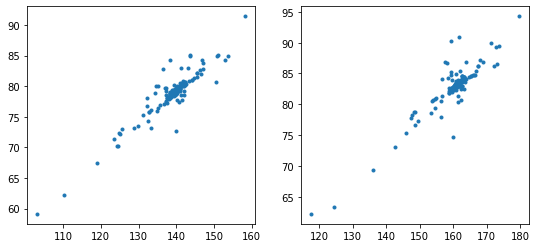

In [53]:
x=gpp
y=ar
i=0
plt.figure(figsize=[9,4])
for exp in ['CTL2010','NDEP']:
    i+=1
    plt.subplot(1,2,i)
    plt.plot(x.sel(exp=exp),y.sel(exp=exp),'.')

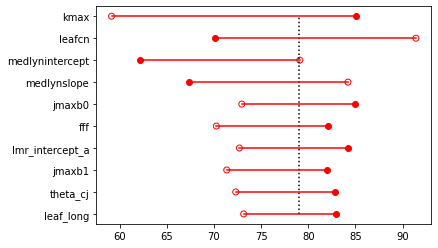

In [50]:
rank_plot(ar.sel(exp='CTL2010'),ds,10)
#plt.xlim([-0.25,0.25])

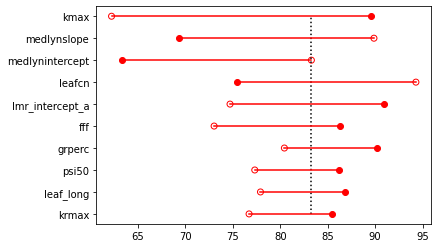

In [51]:
rank_plot(ar.sel(exp='NDEP'),ds,10)
#plt.xlim([-0.25,0.25])

Text(0.5, 0, 'Forcing Scenario')

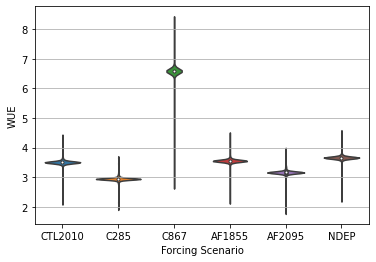

In [27]:




plt.grid(axis='y')
plt.xlabel('Forcing Scenario')


In [17]:
cf=365*24*60*60/2.5e6*la.sum()/1e9
cf

<xarray.DataArray 'landarea' ()>
array(1.70654626)

In [4]:
from skopt.space import Space
from skopt.sampler import Lhs

In [15]:
params=['p1','p2']
n_samples=9
space = Space([(0.,1.) for p in params])
lhs = Lhs(lhs_type="classic", criterion=None)
lhc = np.array(lhs.generate(space.dimensions, n_samples))

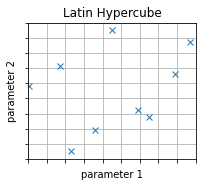

In [48]:
plt.figure(figsize=[3,2.5])
plt.plot(lhc[:,0],lhc[:,1],'x')
plt.xticks(np.arange(10)/9,'')
plt.yticks(np.arange(10)/9,'')
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
plt.title('Latin Hypercube')
plt.xlabel('parameter 1')
plt.ylabel('parameter 2');
plt.savefig('../figs/lhc.png',dpi=300,bbox_inches='tight')

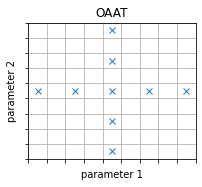

In [49]:
plt.figure(figsize=[3,2.5])
xs=[0.5,5/18,13/18,17/18,1/18,0.5,0.5,0.5,0.5]
ys=[0.5,0.5,0.5,0.5,0.5,5/18,13/18,17/18,1/18]
plt.plot(xs,ys,'x')
plt.xticks(np.arange(10)/9,'')
plt.yticks(np.arange(10)/9,'')
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
plt.title('OAAT')
plt.xlabel('parameter 1')
plt.ylabel('parameter 2');
plt.savefig('../figs/oaat.png',dpi=300,bbox_inches='tight')

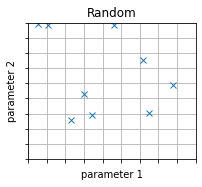

In [45]:
plt.figure(figsize=[3,2.5])
xs=np.random.rand(9)
ys=np.random.rand(9)
plt.plot(xs,ys,'x')
plt.xticks(np.arange(10)/9,'')
plt.yticks(np.arange(10)/9,'')
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
plt.title('Random')
plt.xlabel('parameter 1')
plt.ylabel('parameter 2');
plt.savefig('../figs/rand.png',dpi=300,bbox_inches='tight')

In [41]:
xs=np.random.rand(9)
xs

array([0.59114402, 0.66784686, 0.13666335, 0.35992447, 0.10021469,
       0.17488376, 0.22662776, 0.17807912, 0.30516979])

In [4]:
d='/glade/campaign/asp/djk2120/PPEn11/paramfiles/'
f=d+'OAAT0000.nc'
p0=xr.open_dataset(f)

In [6]:
i=1
f=d+'OAAT'+str(i).zfill(4)+'.nc'
p1=xr.open_dataset(f)

In [20]:
files=glob.glob('/glade/campaign/asp/djk2120/PPEn11/CTL2010/hist/*OAAT*.h0.*')

In [34]:
keys = sorted([f.split('_CTL2010_')[1].split('.')[0] for f in files])
keys.remove('OAAT0000')

In [36]:
dvs=[]
for i,k in enumerate(keys):
    if i%10==0:
        print(k)
    f=d+k+'.nc'
    p1=xr.open_dataset(f)
    for v in p0.data_vars:
        if not p0[v].equals(p1[v]):
            dvs.append(v)

OAAT0001
OAAT0011
OAAT0021
OAAT0031
OAAT0041
OAAT0051
OAAT0061
OAAT0071
OAAT0081
OAAT0091
OAAT0101
OAAT0111
OAAT0121
OAAT0131
OAAT0141
OAAT0151
OAAT0161
OAAT0171
OAAT0181
OAAT0191
OAAT0201
OAAT0211
OAAT0221
OAAT0231
OAAT0241
OAAT0256
OAAT0271
OAAT0281
OAAT0291
OAAT0301
OAAT0311
OAAT0321
OAAT0331
OAAT0341
OAAT0351
OAAT0361
OAAT0371
OAAT0381
OAAT0391
OAAT0401
OAAT0411
OAAT0421
OAAT0431
OAAT0441
OAAT0451
OAAT0461
OAAT0471
OAAT0481
OAAT0491
OAAT0501


In [40]:
len(np.unique(dvs))

206

In [130]:
df=pd.read_csv('cats.csv')

In [131]:
cats={}
a=False
for i,row in df.iterrows():
    if str(row['cat'])=='nan':
        c=row['param']
        a=True
    elif a:
        cats[row['cat']]=c
        a=False



In [132]:
cats

{'a': 'Radiation parameters',
 'b': 'Sensible, latent heat and momentum fluxes',
 'c': 'Soil and snow thermal',
 'd': 'Hydrology',
 'e': 'Snow processes',
 'f': 'Stomatal resistance and photosynthesis',
 'g': 'Photosynthetic capacity (LUNA)',
 'h': 'Plant hydraulics',
 'i': 'Biomass heat storage',
 'j': 'Plant respiration',
 'k': 'Fixation and uptake of nitrogen (FUN)',
 'l': 'Carbon and nitrogen allocation',
 'm': 'Vegetation phenology and turnover',
 'n': 'Decomposition',
 'o': 'External nitrogen cycle',
 'p': 'Plant mortality',
 'q': 'Fire',
 'r': 'Acclimation parameters',
 's': 'Processes and related parameters not included in list',
 't': nan,
 'u': 'Sources of structural uncertainty in photosynthesis equations',
 'v': nan}

In [133]:
vcats=[]
for v in np.unique(dvs):
    vcats.append(cats[df['cat'][df['param']==v].values[0]])

In [134]:
for v in np.unique(dvs):
    if v not in df['param'].values:
        print(v)

In [135]:
cats=np.flip(['Radiation parameters',
      'Snow processes',
      'Soil and snow thermal',
      'Hydrology',
      'Biomass heat storage',
      'Sensible, latent heat and momentum fluxes',
      'Plant hydraulics',
      'Stomatal resistance and photosynthesis',
      'Acclimation parameters',
      'Photosynthetic capacity (LUNA)',
      'External nitrogen cycle',
      'Fixation and uptake of nitrogen (FUN)',
      'Carbon and nitrogen allocation',
      'Vegetation phenology and turnover',
      'Plant respiration',
      'Decomposition',
      'Plant mortality',
      'Fire'])

In [136]:
nx=[]
for c in cats:
    nx.append(np.sum(np.array(vcats)==c))

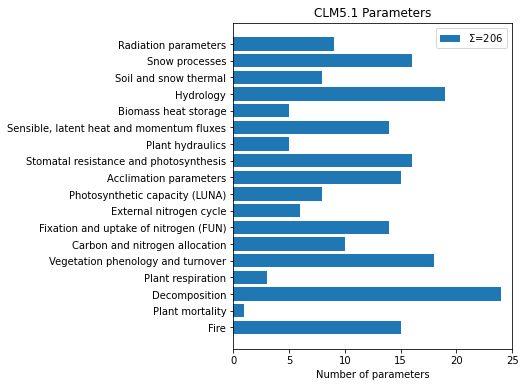

In [138]:
plt.figure(figsize=[5,6])
plt.barh(cats,nx,label=r'$\Sigma$=206')
plt.xlim([0,25])
plt.legend()
plt.title('CLM5.1 Parameters')
plt.xlabel('Number of parameters')
plt.savefig('../figs/bar.pdf',bbox_inches='tight')

In [210]:
npix={}
npix['1deg']=22648
npix['2deg']=5666
npix['4x5']=1764
npix['sg']=400

In [211]:
def sims(ny,npix):
    if ny=='Mtrx':
        ny=140
    sg=400
    pecost=5
    s=t/((ny+10)*npix/sg*pecost)
    
    if s<10:
        s=np.round(s,1)
    else:
        s=int(np.round(s))
    
    return s

In [212]:
t=1e6
pecost=5
nys=[1500,1500,1500,'Mtrx','Mtrx','Mtrx',1500,'Mtrx']
gs =['1deg','2deg','4x5','1deg','2deg','4x5','sg','sg']
svals={}
for ny,g in zip(nys,gs):
    x = "yrs" if ny==1500 else ""
    k=str(ny)+x+'-'+g
    svals[k]=sims(ny,npix[g])

In [213]:
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

In [215]:
ds=xr.open_dataset('/glade/u/home/djk2120/ppe_clean/pyth/clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
lons=xr.DataArray([c[0] for c in ds.rcent_coords.values],dims='lon')
lats=xr.DataArray([c[1] for c in ds.rcent_coords.values],coords=[lons])

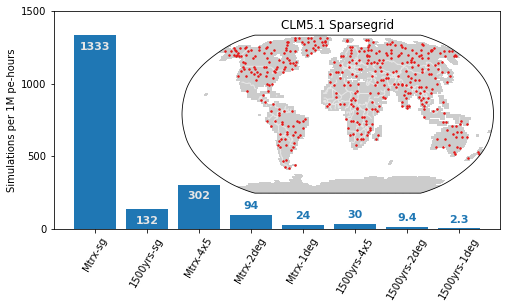

In [229]:
fig=plt.figure(figsize=[8,4])
ax0=fig.add_subplot(111)
x=np.flip([m for m in svals])
y=[svals[m] for m in x]
ax0.bar(x,y)
ax0.set_xticklabels(x,rotation=60)
ax0.set_ylabel('Simulations per 1M pe-hours')
ax0.set_ylim([0,1500]);
ax0.set_yticks(500*np.arange(4))

for i in range(3):
    c=0.9*np.ones(3)
    plt.text(i,y[i]-100,y[i],ha='center',color=c,fontsize=11,fontweight='bold')
    
for i in range(3,8):
    c='C0'
    plt.text(i,y[i]+40,y[i],ha='center',color=c,fontsize=11,fontweight='bold')


axs = fig.subplot_mosaic('AA;XB;CC',gridspec_kw={'height_ratios': [0.5,7, 1],'width_ratios': [1, 4]},
                             subplot_kw={'projection': ccrs.Robinson()})
axs['A'].set_axis_off()
axs['C'].set_axis_off()
axs['X'].set_axis_off()

ax=axs['B']

cmap=ListedColormap(0.8*np.ones(3))
x=ds.landfrac_orig>0
mappable = x.where(x).plot(transform=ccrs.PlateCarree(),ax=ax,add_colorbar=False,cmap=cmap)
lats.plot.line('.',transform=ccrs.PlateCarree(),ax=ax,color=[0.9,0.1,0.1],ms=3,label='sparsegrid')
ax.set_title('CLM5.1 Sparsegrid')
transform = ccrs.PlateCarree()._as_mpl_transform(ax)
#ax.coastlines(color='grey')
ax.add_feature(cfeature.BORDERS,edgecolor=[0.9,0.9,0.9]);
#plt.savefig('../figs/sims.pdf',bbox_inches='tight')

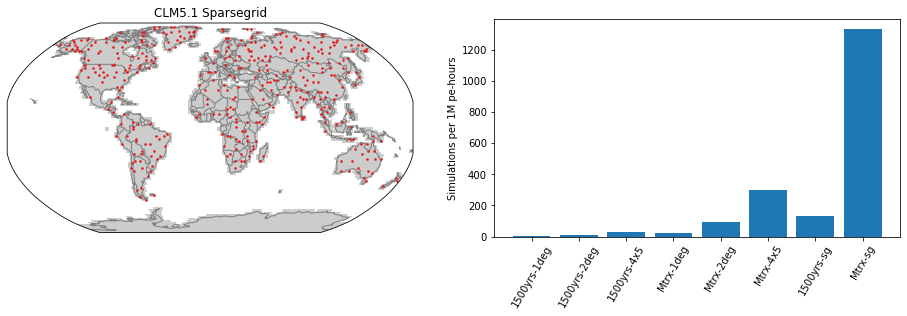

In [102]:

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121,projection=ccrs.Robinson())
ax.set_extent([-180, 180,-90,90], crs=ccrs.PlateCarree())


ax = fig.add_subplot(122)


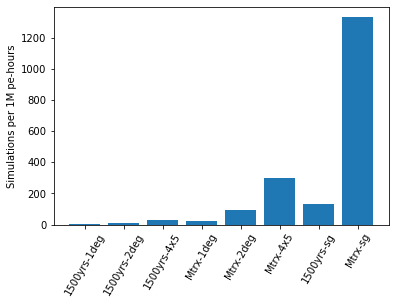

In [18]:

#plt.savefig('../figs/sims.pdf',bbox_inches='tight')

# d='/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/'
f='surfdata_4x5_16pfts_simyr2000_c170428.nc'
ds=xr.open_dataset(d+f)
(ds.LANDFRAC_PFT>0).sum()

In [150]:
d='/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/ctsm5.1.dev052/'
f='surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1700_c210820.nc'
ds=xr.open_dataset(d+f)
((ds.LANDFRAC_PFT)>0).sum()

<xarray.DataArray 'LANDFRAC_PFT' ()>
array(22648)

<xarray.DataArray 'LANDFRAC_PFT' ()>
array(22648)